In [3]:
import csv
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import random
import seaborn as sb
import tensorflow as tf
from tensorflow.python.framework import ops

In [4]:
train = pd.read_csv(r'C:\Users\44788\Desktop\coding\pynbs\Kaggle\train.csv')
test = pd.read_csv(r'C:\Users\44788\Desktop\coding\pynbs\Kaggle\test.csv')

In [5]:
def model_data(input_df, col_start): 
    Xlist = []
    pixel_names = list(input_df.columns[col_start:])
    for pixel in pixel_names:
        Xlist.append(list(input_df[pixel]))
    Xarray = np.array(Xlist)
    image_list = []
    for image in Xarray.T:
        image_list.append(np.reshape(image, (28,28)))
    image_list = np.array(image_list)
    return image_list
Xtrain = model_data(train, 1)

In [6]:
Xtest = model_data(test, 0)

In [7]:
Ytrain = np.expand_dims(np.array(train['label']), 1)

(<matplotlib.axes._subplots.AxesSubplot at 0x20e80187f60>,
 (42000, 28, 28),
 array([4], dtype=int64))

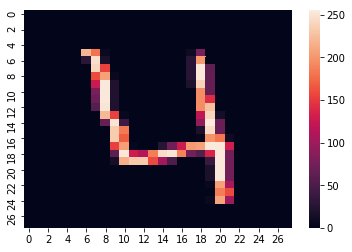

In [8]:
example = 3
sb.heatmap(Xtrain[example]), Xtrain.shape, Ytrain[example]

In [18]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
    """
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0), name='X') # none refers to the batch size so it can be specic
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name='Y')   
    return X, Y

In [19]:
def initialize_parameters():
    W1 = tf.get_variable('W1', shape=(5,5,1,6), initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable('W2', shape=(5,5,6,16), initializer=tf.contrib.layers.xavier_initializer(seed=0))
    parameters = {"W1": W1,
                  "W2": W2}
    return parameters

In [20]:
def forward_propagation(X, parameters):
    W1 = parameters['W1']
    W2 = parameters['W2']
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'VALID') 
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'VALID')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2, ksize = [1,2,2,1], strides = [1,2,2,1], padding = 'VALID')
    F = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(F, 9, activation_fn=None)
    return Z3

In [21]:
def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y))
    return cost

In [22]:
def random_mini_batches(X_train, Y_train, minibatch_size):
    Xbatches = np.array_split(X_train,660,axis=0)
    Ybatches = np.array_split(Y_train,660,axis=0)
    batchlist = [(np.expand_dims(Xbatch, 3), Ybatch) for Xbatch, Ybatch in zip(Xbatches, Ybatches)]
    return batchlist

In [25]:
def model(X_train, Y_train, learning_rate = 0.00001,num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    (m, n_H0, n_W0) = X_train.shape 
    minibatches = random_mini_batches(X_train, Y_train, minibatch_size)
    n_C0 = 1
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = 660 # number of minibatches of size minibatch_size in the train set
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], {X: minibatch_X, Y: minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    predict_op = tf.argmax(Z3, 1)
    correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print(accuracy)
    return parameters, accuracy

Cost after epoch 0: 3953.675178
Cost after epoch 5: 113237.311731
Cost after epoch 10: 332628.487263
Cost after epoch 15: 629256.321591
Cost after epoch 20: 930979.406629
Cost after epoch 25: 1296804.048580
Cost after epoch 30: 1717185.752652
Cost after epoch 35: 2189641.292614
Cost after epoch 40: 2712843.933902
Cost after epoch 45: 3285717.745833
Cost after epoch 50: 3907241.262879
Cost after epoch 55: 4576630.408333
Cost after epoch 60: 5293089.248485
Cost after epoch 65: 6055907.193939
Cost after epoch 70: 6865000.490909
Cost after epoch 75: 7718948.839394
Cost after epoch 80: 8618007.946970
Cost after epoch 85: 9561270.435606
Cost after epoch 90: 10547848.199242
Cost after epoch 95: 11577282.596970


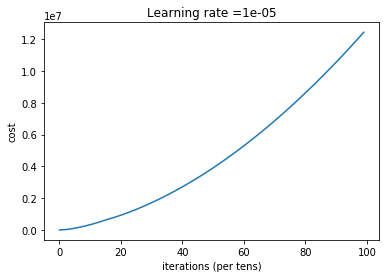

Tensor("Mean_1:0", shape=(), dtype=float32)


In [26]:
parameters, accuracy = model(Xtrain, Ytrain)